# Introduction

Many American cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

Hadi Fanaee-T at the University of Porto compiled this data into a CSV file, which you'll be working with in this project. The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. You can download the data from the University of California, Irvine's website. For more description about the columns see http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset

From this data, can we predict the total number of bike rentals (cnt) based on the given predictor variables, such as season, year, month etc? We will try to do this using three different models: Linear Regression, Decision Tree, and Random Forest.

In [3]:
#Import necessary libraries for data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Load bike rentals data into a pandas dataframe
bike_rentals = pd.read_csv("bike_rental_hour.csv")

bike_rentals.drop(columns = ['casual', 'registered', 'instant'], inplace = True)
bike_rentals.head(10)

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,16
1,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,40
2,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,32
3,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,13
4,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,1
5,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,1
6,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2
7,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,3
8,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,8
9,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,14


For more information about the above columns, visit the following link: https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset

Let's plot a histogram of the total number of bike rentals and see what we will find.

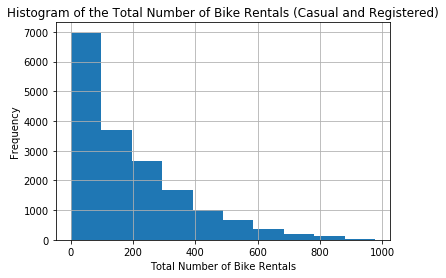

In [5]:
bike_rentals.hist(column = 'cnt')
plt.title('''Histogram of the Total Number of Bike Rentals (Casual and Registered)''')
plt.xlabel("Total Number of Bike Rentals")
plt.ylabel("Frequency")
plt.show()

This histogram simply indicates that most total number of bike rentals at a given time frame are under 100, and there are a few instances where the total number of bike rentals are over 600. Next, let's compute the correlation matrix and see if there is a pair of features that are correlated with one another.

In [3]:
#Computing the correlation matrix for our data
corr_bike_rentals = bike_rentals.corr()

sub_columns = ['season', 'yr', 'mnth', 
               'holiday', 'weekday',
               'workingday', 'weathersit', 'hum', 
               'windspeed', 'cnt']
corr_bike_rentals[sub_columns].loc[sub_columns]


,season,yr,mnth,holiday,weekday,workingday,weathersit,hum,windspeed,cnt
season,1.000000,-0.010742,0.830386,-0.009585,-0.002335,0.013743,-0.014524,0.150625,-0.149773,0.178056
yr,-0.010742,1.000000,-0.010473,0.006692,-0.004485,-0.002196,-0.019157,-0.083546,-0.008740,0.250495
mnth,0.830386,-0.010473,1.000000,0.018430,0.010400,-0.003477,0.005400,0.164411,-0.135386,0.120638
holiday,-0.009585,0.006692,0.018430,1.000000,-0.102088,-0.252471,-0.017036,-0.010588,0.003988,-0.030927
weekday,-0.002335,-0.004485,0.010400,-0.102088,1.000000,0.035955,0.003311,-0.037158,0.011502,0.026900
workingday,0.013743,-0.002196,-0.003477,-0.252471,0.035955,1.000000,0.044672,0.015688,-0.011830,0.030284
weathersit,-0.014524,-0.019157,0.005400,-0.017036,0.003311,0.044672,1.000000,0.418130,0.026226,-0.142426
hum,0.150625,-0.083546,0.164411,-0.010588,-0.037158,0.015688,0.418130,1.000000,-0.290105,-0.322911
windspeed,-0.149773,-0.008740,-0.135386,0.003988,0.011502,-0.011830,0.026226,-0.290105,1.000000,0.093234
cnt,0.178056,0.250495,0.120638,-0.030927,0.026900,0.030284,-0.142426,-0.322911,0.093234,1.000000


As you can see, there are at least two features in the data that are pairwise correlated. For example, if you look at season and month, they both have an associated correlation of 0.83. This is important because if we apply a linear regression model based on the above features, it will not perform well simply because linear regression models perfrom best if any pairwise features are not correlated with one another, i.e their correlation is close to 0.

# Feature Engineering

Before we can fit a model to our data, it is essential to engineer some features in our data. For now let's add a time label column.

In [6]:
# time_label simply determines whether the hr number
# represents morning (1), afternoon (2), evening (3), 
# and night (4)
def assign_label(hr):
    if 6 <= hr and hr <= 12:
        return 1
    elif 12 <= hr and hr <= 18:
        return 2
    elif 18 <= hr and hr <= 24:
        return 3
    else:
        return 4

bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)
bike_rentals.head(10)

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,time_label
0,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,16,4
1,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,40,4
2,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,32,4
3,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,13,4
4,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,1,4
5,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,1,4
6,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,1
7,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,3,1
8,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,8,1
9,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,14,1


# Import SKLearn Libraries, Train Test Split

In [8]:
# Use mean absolute error from sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Split the data so that 80% of our data is our train set,
# while the rest is our test set.
train = bike_rentals.sample(frac = 0.8)
train.head(5)

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,time_label
6293,2011-09-24,4,0,9,19,0,6,0,1,0.62,0.5606,0.88,0.0000,308,3
14492,2012-09-01,3,1,9,1,0,6,0,1,0.72,0.6970,0.74,0.1343,79,4
3842,2011-06-14,2,0,6,0,0,2,1,1,0.60,0.6212,0.49,0.1940,31,4
2984,2011-05-09,2,0,5,6,0,1,1,1,0.44,0.4394,0.72,0.2537,89,1
7811,2011-11-27,4,0,11,2,0,0,0,1,0.34,0.3636,0.81,0.0000,31,4


In [10]:
# Preview our test set
test = bike_rentals[~bike_rentals.index.isin(train.index)]
test.head(5)

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,time_label
9,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,14,1
12,2011-01-01,1,0,1,12,0,6,0,1,0.42,0.4242,0.77,0.2836,84,1
14,2011-01-01,1,0,1,14,0,6,0,2,0.46,0.4545,0.72,0.2836,106,2
22,2011-01-01,1,0,1,22,0,6,0,2,0.40,0.4091,0.94,0.2239,28,3
25,2011-01-02,1,0,1,1,0,0,0,2,0.44,0.4394,0.94,0.2537,17,4


In [11]:
# Here are the predictor variables we will use to predict cnt.
predictors = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
              'workingday', 'weathersit', 'temp', 'atemp', 'hum', 
              'windspeed', 'time_label']

# Linear Regression

In [12]:
linear_regression = LinearRegression()
linear_regression.fit(train[predictors], train['cnt'])
prediction = linear_regression.predict(test[predictors])
mean_absolute_error(test['cnt'], prediction)

98.32210396137293

Using a linear regression model gave us a prediction on the total number of bike rentals that is off by approximately 98 bikes.

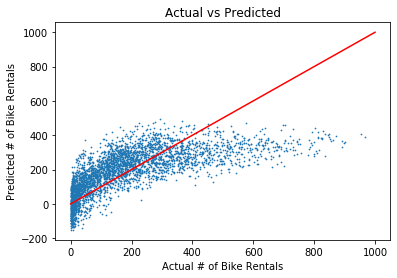

In [9]:
plt.xlabel("Actual # of Bike Rentals")
plt.ylabel("Predicted # of Bike Rentals")
plt.title("Actual vs Predicted")
plt.scatter(test['cnt'], prediction, s = 0.5)
plt.plot(np.linspace(0, 1000), np.linspace(0, 1000), color = 'red')
plt.show()

The above graph indicates that we are on average overpredicting the total number of bike rentals. Ideally, we want our points close to the read line.

# Decision Tree

In [13]:
decision_tree_regression = DecisionTreeRegressor()
decision_tree_regression.fit(train[predictors], train['cnt'])
prediction = decision_tree_regression.predict(test[predictors])
mean_absolute_error(test['cnt'], prediction)

34.293153049482164

Using a Decision Tree model gave us a prediction on the total number of bike rentals that is off by approximately 34 bikes. This is significantly much better than using linear regression.

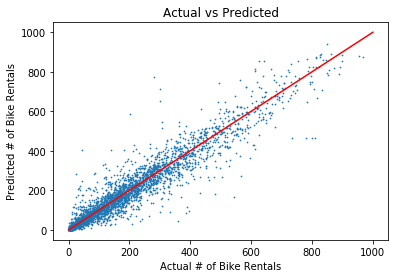

In [11]:
plt.xlabel("Actual # of Bike Rentals")
plt.ylabel("Predicted # of Bike Rentals")
plt.title("Actual vs Predicted")
plt.scatter(test['cnt'], prediction, s = 0.5)
plt.plot(np.linspace(0, 1000), np.linspace(0, 1000), color = 'red')
plt.show()

# Random Forest

In [12]:
random_forest_regression = RandomForestRegressor(n_estimators = 200)
random_forest_regression.fit(train[predictors], train['cnt'])
prediction = random_forest_regression.predict(test[predictors])
mean_absolute_error(test['cnt'], prediction)

24.434726002109702

Using a Random Forest model gave us a prediction on the total number of bike rentals that is off by approximately 24 bikes. This performs slightly better than a single decision tree. Moreover, if you increase the number of decision trees in your random forest, you would get better results.

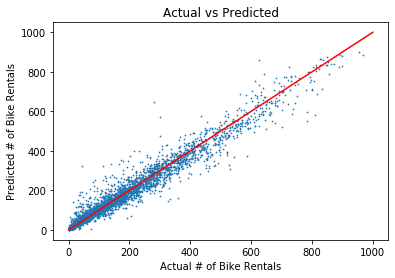

In [13]:
plt.xlabel("Actual # of Bike Rentals")
plt.ylabel("Predicted # of Bike Rentals")
plt.title("Actual vs Predicted")
plt.scatter(test['cnt'], prediction, s = 0.5)
plt.plot(np.linspace(0, 1000), np.linspace(0, 1000), color = 'red')
plt.show()